# 1. Import and Install Dependencies

In [ ]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [2]:
# Import necessary libraries for this project 

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

# 2. Keypoints using MP Holistic

In [3]:
# Initialize the keypoint detection holistics objects using mediapipe

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [13]:
# The below function is used to detect the keypoints from an input frame using the model and display the image with the annotated keypoints

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [14]:
# The below function draws the landmarks over the face and along the arms on the input frame

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [15]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
# Test a sample using live camera feed

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [9]:
# Draw landmarks on latest frame from the live camera feed from the above cell

draw_landmarks(frame, results)

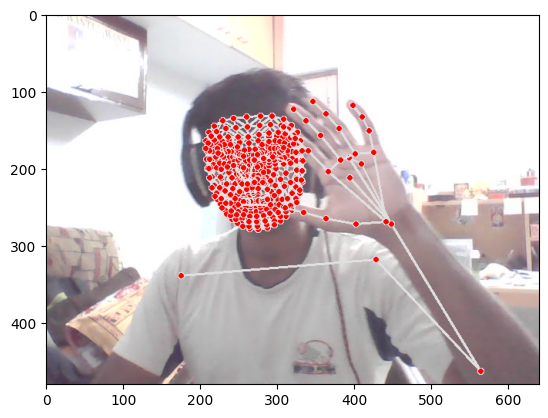

In [14]:
# Show the annotated image

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [15]:
# Number of keypoints in left hand landmarks

len(results.left_hand_landmarks.landmark)

21

In [16]:
# Get the coordinates of the landmarks and add them to a list 

pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [17]:
# Get the data to produce equal amounts of results as landmarks (if there is no landmark then it returns 0)

pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [18]:
# Check example for face 

face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [16]:
# Function to extract keypoints and the array of coordinates from each landmark

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [20]:
# Test the above function

result_test = extract_keypoints(results)

In [21]:
result_test

array([ 0.40798369,  0.46023878, -0.56896758, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [18]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou', 'what', 'you', 'name', 'pig', 'monkey', 'horse', 'sukuna', 'gojo', 'megumi', 'pray'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [23]:
# Create the training directories

os.makedirs(DATA_PATH, exist_ok=True)

for action in actions: 
    # dirr = os.path.join(DATA_PATH, action)
    # os.makedirs(dirr, exist_ok=True)
    # dirmax = np.max(np.array(os.listdir(dirr)).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)), exist_ok=True)
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [29]:
# This cell opens the live camera feed and captures 30 numpy array frames for 30 different sequences of each sign

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions[12:]:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [31]:
label_map = {label:num for num, label in enumerate(actions)}

In [32]:
label_map

{'hello': 0,
 'thanks': 1,
 'iloveyou': 2,
 'what': 3,
 'you': 4,
 'name': 5,
 'pig': 6,
 'monkey': 7,
 'horse': 8,
 'sukuna': 9,
 'gojo': 10,
 'megumi': 11,
 'pray': 12}

In [33]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [34]:
np.array(sequences).shape

(390, 30, 1662)

In [35]:
np.array(labels).shape

(390,)

In [36]:
X = np.array(sequences)

In [37]:
X.shape

(390, 30, 1662)

In [38]:
y = to_categorical(labels).astype(int)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [40]:
y_test.shape

(20, 13)

# 7. Build and Train LSTM Neural Network

In [42]:
# TensorBoard callback to view live performance of model while its training

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [43]:
actions

array(['hello', 'thanks', 'iloveyou', 'what', 'you', 'name', 'pig',
       'monkey', 'horse', 'sukuna', 'gojo', 'megumi', 'pray'], dtype='<U8')

In [44]:
# Build the deep learning model

model = Sequential()

model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [45]:
# Compile the model

model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'categorical_accuracy'])

In [46]:
# Get the model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           916992    
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           394240    
                                                                 
 lstm_2 (LSTM)               (None, 30, 128)           197120    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)               

In [ ]:
# Train the model

model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

# 8. Make Predictions

In [48]:
# Get predictions

res = model.predict(X_test)

1/1 [==============================] - 1s 528ms/step


In [49]:
# Get the corresponding sign

actions[np.argmax(res[4])]

'horse'

In [2]:
actions[np.argmax(y_test[4])]

horse


# 9. Save Weights

In [51]:
# Save the model weights

model.save('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [10]:
# Load the saved model

model = tf.keras.models.load_model('action.h5') 

In [57]:
# Get predictions on the testing data

yhat = model.predict(X_test)

1/1 [==============================] - 1s 534ms/step


In [58]:
# Get data ready to plot confusion matrix

ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [59]:
# Plot confusion matrix

multilabel_confusion_matrix(ytrue, yhat)

array([[[19.,  0.],
        [ 1.,  0.]],

       [[17.,  0.],
        [ 3.,  0.]],

       [[17.,  0.],
        [ 3.,  0.]],

       [[18.,  0.],
        [ 2.,  0.]],

       [[18.,  0.],
        [ 2.,  0.]],

       [[19.,  0.],
        [ 1.,  0.]],

       [[19.,  0.],
        [ 1.,  0.]],

       [[17.,  0.],
        [ 3.,  0.]],

       [[ 0., 20.],
        [ 0.,  0.]],

       [[19.,  0.],
        [ 1.,  0.]],

       [[19.,  0.],
        [ 1.,  0.]],

       [[19.,  0.],
        [ 1.,  0.]],

       [[19.,  0.],
        [ 1.,  0.]]])

# 11. Test in Real Time

In [25]:
# Define the color for each sign

colors = [
    (245, 117, 16),  # Orange
    (117, 245, 16),  # Lime Green
    (16, 117, 245),  # Blue
    (245, 16, 117),  # Pink
    (117, 16, 245),  # Purple
    (16, 245, 117),  # Sea Green
    (245, 245, 16),  # Yellow
    (16, 245, 245),  # Cyan
    (245, 16, 245),  # Magenta
    (192, 192, 192),  # Silver
    (128, 0, 128),    # Purple
    (0, 128, 128),     # Teal
    (0, 128, 0),
]

In [28]:
# Function to put the predicted sign text over each image

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        # print(num)
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [29]:
# Live camera testing

sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti